In [1]:
##TODO
# Note the issues with the dataset
# Ask Raúl abput customising the colours on the network graph

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from ridgeplot import ridgeplot
from numpy import linspace
from bokeh.embed import components
from bokeh.models import Circle, MultiLine, HoverTool
from bokeh.plotting import figure, from_networkx, show, output_file
from bokeh.plotting import ColumnDataSource
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option("display.precision", 2)
products=pd.read_csv("products.csv")
sales=pd.read_csv("sales.csv")
products=products.drop("Unnamed: 0",axis=1)
sales=sales.drop("Unnamed: 0",axis=1)
sales["invoice_date"]=pd.to_datetime(sales["invoice_date"])
sales["week"]=pd.DatetimeIndex(sales["invoice_date"]).week
sales["month"]=pd.DatetimeIndex(sales["invoice_date"]).month
sales["year"]=pd.DatetimeIndex(sales["invoice_date"]).year
sales["weekday"]=pd.DatetimeIndex(sales["invoice_date"]).day_of_week

C:\Users\giorg\AppData\Local\Temp\ipykernel_10144\14222735.py:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  sales["week"]=pd.DatetimeIndex(sales["invoice_date"]).week


In [35]:
# FUNCTIONS

def churn(x,i):
    j=i+1
    a=((x["Customers"].loc[(x["month"]==j) & x["month_end"]]).values)
    b=((x["Customers"].loc[(x["month"]==j) & x["month_beg"]]).values)
    c=(a-b)/a
    try:
        return(round(c.item()*100,2))
    except ValueError:
        return(0)

def hot_encode(x):
    if(x<=0):
        return(0)
    elif(x>=0):
        return(1)

def stringify(x):
    return(x.apply(lambda x:", ".join(list(x)))).astype("unicode")

def common_items(x):
    temp=pd.merge(sales,products,on="ASIN")
    temp=(temp[(temp["month"]==x)&(temp["year"]==2019)]
                    .groupby(by=["InvoiceNo","title",])["Quantity"]
                    .sum().unstack().reset_index().fillna(0)
                    .set_index("InvoiceNo"))
    temp_encoded=temp.applymap(hot_encode)
    frq_items=apriori(temp_encoded,min_support=0.04,use_colnames=True)
    rules=association_rules(frq_items, metric="lift", min_threshold=1.2)
    rules=rules.sort_values(["confidence","lift"], 
                        ascending=[False,False])
    rules["antecedents"]=stringify(rules["antecedents"])
    rules["consequents"]=stringify(rules["consequents"])
    return(rules[["antecedents","consequents","confidence"]])

def node(x):
    months={1:"January", 2:"February", 3:"March", 4:"April",
        5:"May", 6:"June", 7:"July", 8:"August",9:"September",
        10:"October", 11:"November", 12:"December"}
    title="Most common item pairs for "+months[x]+" 2019"
    g=nx.from_pandas_edgelist(common_items(x),
                            "antecedents","consequents","confidence")
    HOVER_TOOLTIPS=[("Product","@index")]
    nodegraph=figure(tooltips=HOVER_TOOLTIPS, 
                tools="pan,wheel_zoom,save",
                active_scroll="wheel_zoom",
                title=title)
    network_graph=from_networkx(g, nx.spring_layout)
    network_graph.node_renderer.glyph=Circle(size=15, 
                                            fill_color="crimson")
    network_graph.edge_renderer.glyph=MultiLine(line_alpha=0.5, 
                                                line_width=1)
    nodegraph.renderers.append(network_graph)
    return(nodegraph)

In [4]:
# Get a list of products that are above the 75th pctl in terms of
# volume sold
sales100=sales.copy(deep=True)
sales100=sales100.groupby(by="ASIN").sum().reset_index()
sales100=sales100.loc[sales100["total_sale"]>6.61e+04]
a=sales100.columns
a=[i for i in a if i not in("ASIN","total_sale")]
sales100.drop(a,axis=1,inplace=True)
sales100.rename({"total_sale":"Total sales"},axis=1,inplace=True)
# Get a list of products that are above the 75th pctl in terms of 
# total revenue
quantity100=sales.copy(deep=True)
quantity100=quantity100.groupby(by="ASIN").sum().reset_index()
quantity100=quantity100.loc[quantity100["Quantity"]>1336]
a=quantity100.columns
a=[i for i in a if i not in ("ASIN","Quantity")]
quantity100.drop(a,axis=1,inplace=True)
# Find the common items between the two lists
top100=pd.merge(sales100,quantity100,on="ASIN",how="inner")


In [5]:
# Check if we can differentiate retail vs wholesale customers
# According to "E-commerce statistics for individuals" from Eurostat,
# average per capite electronics e-commerce market 
# in the EU is ~500-750€ per three months. Since an individual may still make 
# orders in the low thousands, we'll consider 5000€ as our benchmark
temp=sales.copy(deep=True)
temp["orders"]=1
temp=temp.groupby(by="CustomerID").sum()
temp.reset_index(inplace=True)
a=(temp["total_sale"].loc[temp["total_sale"]>5000].count())/len(temp)
print("Approximately",round(a,2)*100,"% of the customers made "\
    "wholesale business over 5000€")


Approximately 91.0 % of the customers made wholesale business over 5000€


Text(0.5, 0, 'Inactive users defined as no transactionsin the last 6 months')

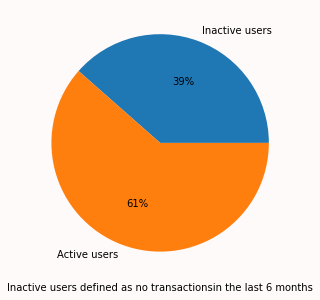

In [6]:
# Check for customers who haven't shopped for a while
temp=sales.groupby(by=["CustomerID","invoice_date"]).sum()
temp.reset_index(inplace=True)
a=list(temp.columns)
a=[i for i in a if i not in ("CustomerID","invoice_date")]
temp.drop(a,axis=1,inplace=True)
temp=temp.groupby(by="CustomerID")\
    .min().sort_values(by="invoice_date",ascending=False)
temp=len(temp.loc[temp["invoice_date"]<"2019-06-01"])
lst=[temp,sales["CustomerID"].nunique()]

# Plot them to visualise better
fig,ax=plt.subplots(figsize=(5,5),facecolor="snow")
label=["Inactive users","Active users"]
plt.pie(lst, labels=label, autopct="%1.0f%%")
plt.xlabel("Inactive users defined as no transactions"\
    "in the last 6 months")

Text(0, 0.5, '')

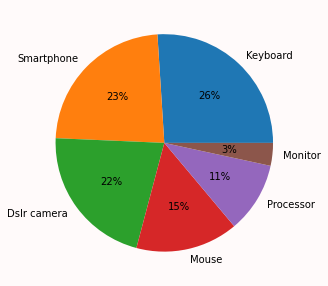

In [7]:
fig,ax=plt.subplots(figsize=(5,5),facecolor="snow")
temp=products["product_type"].value_counts()
label=[i for i in temp.index]
label=[i.capitalize() for i in label]
temp.plot.pie(
        labels=label, autopct="%1.0f%%")
ax.set_ylabel("")

In [163]:
products["rating"].nunique()

26

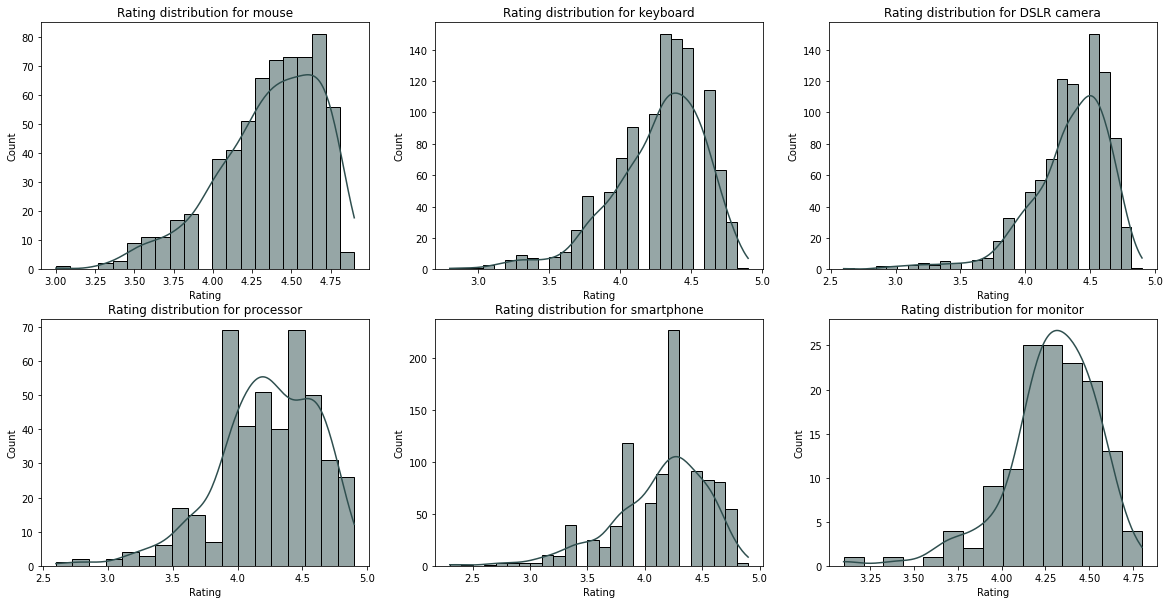

In [160]:
# Plotting the rating distribution for each product type
temp=products.copy(deep=True)
fig,ax=plt.subplots(2,3,figsize=(20,10))
for i, x in zip(temp["product_type"].unique(), ax.flat):
        temp=products.copy(deep=True)
        temp=temp.loc[temp["product_type"]==i]
        sns.histplot(data=temp["rating"], kde=True, 
                color="darkslategrey", ax=x)
        i=i.replace("dslr camera", "DSLR camera")
        x.set(title="Rating distribution for "+i, xlabel="Rating")

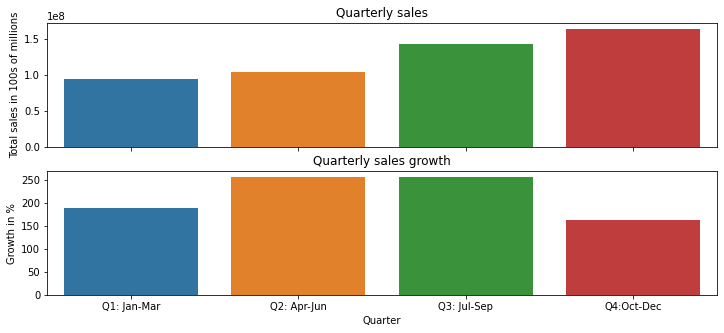

In [8]:
# Calculating quarterly revenue behaviour
temp=sales.copy(deep=True)
temp=temp.loc[temp["year"]==2019]
temp=temp.groupby(by="month").sum()
temp.reset_index(inplace=True)
lst=pd.DataFrame(columns=["date","Growth"])
lst1=pd.DataFrame(columns=["date","sales"])
x=0
for i in range(0,12,3):
    lst.loc[x,"date"]=temp.loc[i,"month"]
    lst.loc[x,"Growth"]=(((temp.loc[i:(i+2),"total_sale"].sum())
                        -(temp.loc[i,"total_sale"].sum()))
                        /(temp.loc[i,"total_sale"].sum()))
    lst1.loc[x,"date"]=temp.loc[i,"month"]
    lst1.loc[x,"sales"]=(temp.loc[i:(i+2),"total_sale"].sum())
    x+=1

# Plotting our results
fig,ax=plt.subplots(2,1,figsize=(12,5), sharex=True)
sns.barplot(ax=ax[0], data=lst1, x="date", y="sales")
sns.barplot(ax=ax[1], x=lst["date"], y=lst["Growth"]*100)
ax[0].set(title="Quarterly sales", 
            xlabel="", ylabel="Total sales in 100s of millions")
ax[1].set(title="Quarterly sales growth", 
            xlabel="Quarter", ylabel="Growth in %")
ax[1].set_xticks([0,1,2,3], 
                ["Q1: Jan-Mar", "Q2: Apr-Jun", 
                "Q3: Jul-Sep", "Q4:Oct-Dec"])

[Text(0.5, 0, '')]

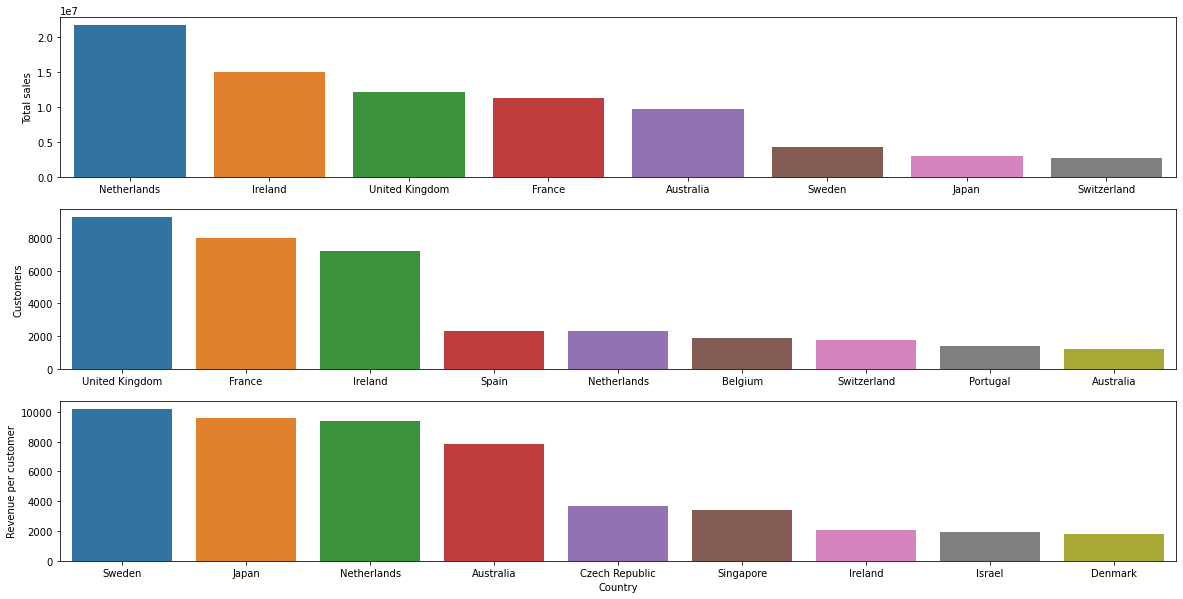

In [9]:
# Find the revenue per customer for each country 
temp=sales.copy(deep=True)
temp["ca"]=1
temp=temp.groupby(by="Country").sum()
a=list(temp.columns)
a=[i for i in a if i not in ("total_sale","ca")]
temp.drop(a,axis=1,inplace=True)
temp["Revenue per customer"]=temp["total_sale"]/temp["ca"]
temp.rename({"total_sale":"Total sales", "ca":"Customers"},
            axis=1, inplace=True)
temp.reset_index(inplace=True)

# Plot the top 8 from each column
fig,ax=plt.subplots(3,1,figsize=(20,10))
temp=temp.sort_values(by="Total sales",ascending=False)
temp.reset_index(inplace=True,drop=True)
sns.barplot(ax=ax[0],x=temp.loc[1:8,"Country"],
            y=temp.loc[1:8,"Total sales"])
temp=temp.sort_values(by="Customers",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[1],x=temp.loc[1:9,"Country"],
            y=temp.loc[1:9,"Customers"])
temp=temp.sort_values(by="Revenue per customer",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[2],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Revenue per customer"])
ax[0].set(xlabel="")
ax[1].set(xlabel="")

[Text(0.5, 0, '')]

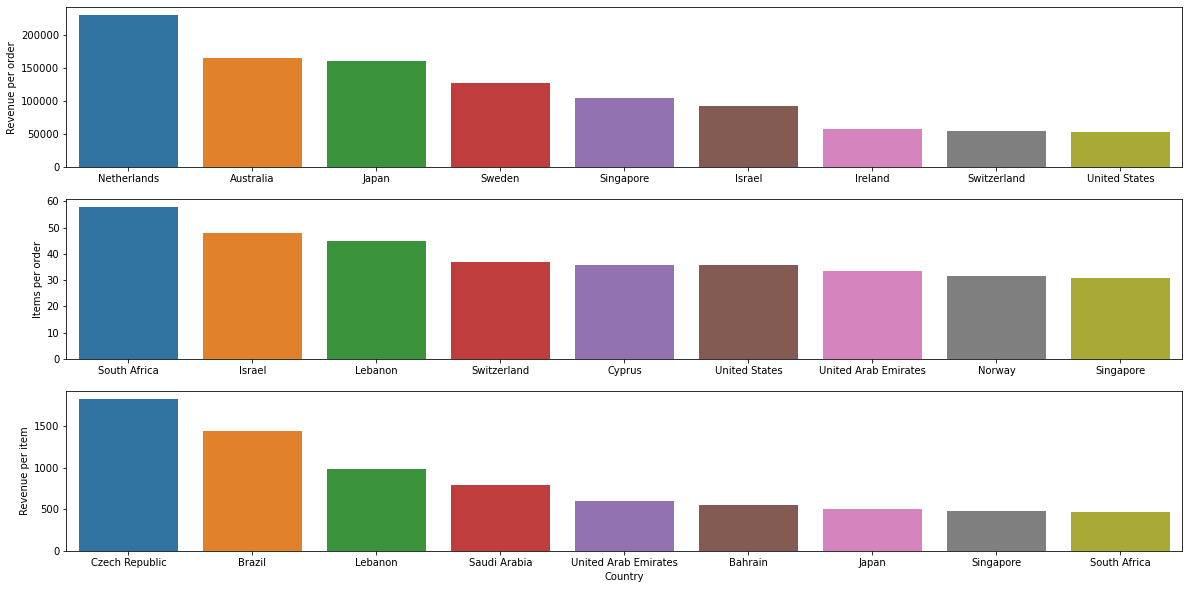

In [10]:
# Calculate average order size and revenue for each country
temp=sales.copy(deep=True)
temp["Items"]=1
temp=temp.groupby(by=["Country","InvoiceNo"]).sum()
temp.reset_index(inplace=True)
temp.rename({"weekday":"no_inv"},axis=1,inplace=True)
temp["no_inv"]=1
temp=temp.groupby(by="Country").sum()
temp["Items per order"]=temp["Items"]/temp["no_inv"]
temp["Revenue per order"]=temp["total_sale"]/temp["no_inv"]
temp["Revenue per item"]=temp["Revenue per order"]/temp["Items"]
a=list(temp.columns)
a=[i for i in a if i not in ("Items per order", 
    "Revenue per order", "Revenue per item")]
temp.drop(a,axis=1,inplace=True)

# Plot the top 8 from each column
fig,ax=plt.subplots(3,1,figsize=(20,10))
temp=temp.sort_values(by="Revenue per order",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[0],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Revenue per order"])
temp=temp.sort_values(by="Items per order",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[1],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Items per order"])
temp=temp.sort_values(by="Revenue per item",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[2],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Revenue per item"])
ax[0].set(xlabel="")
ax[1].set(xlabel="")

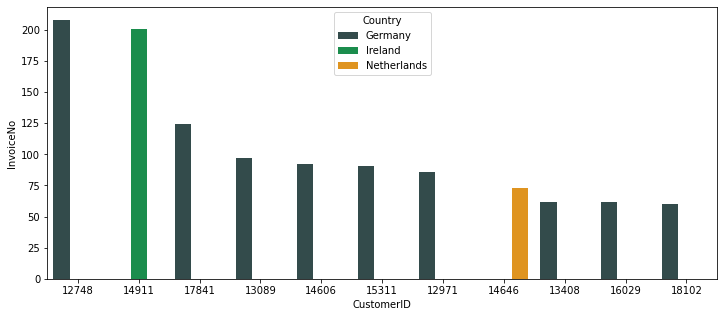

In [11]:
# Finding the customers with most orders
temp=sales.copy(deep=True)
temp=temp.groupby(by=["CustomerID", "InvoiceNo", "Country"]).count()
temp.reset_index(inplace=True)
temp=temp.groupby(by=["CustomerID","Country"]).count()
temp=temp.sort_values("InvoiceNo", ascending=False)
temp.reset_index(inplace=True)
temp["CustomerID"]=temp["CustomerID"].astype(str)

# Now let's plot them
fig,ax=plt.subplots(figsize=(12,5))
colours={"Germany":"#2f4f4f","Netherlands":"#FF9B00","Ireland":"#08a04b"}
sns.barplot(x=temp.loc[0:10,"CustomerID"], y=temp["InvoiceNo"], 
            hue=temp.loc[0:10,"Country"], palette=colours)
plt.ylabel=("Number of orders")


Text(0.5, 0, 'Day of the week')

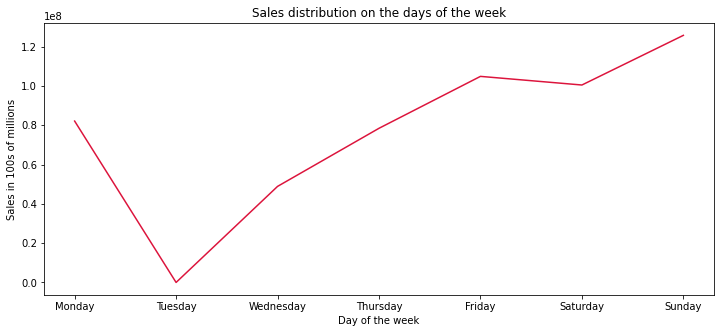

In [12]:
# Let's plot the total sales for each day of the week
# Interestingly enough, there are no orders on Tuesdays. 
# That can not be correct, so we assume it's due to date corruption 
temp=sales.groupby(by="weekday").sum()
a=list(temp.columns)
a=[i for i in a if i not in ("total_sale")]
temp.drop(a, axis=1, inplace=True)
temp.loc[1]=0
temp.reset_index(inplace=True)

fig,ax=plt.subplots(figsize=(12,5))
sns.lineplot(data=temp, x="weekday", y="total_sale",
            color="crimson")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday",
            "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Sales distribution on the days of the week")
ax.set_ylabel("Sales in 100s of millions")
plt.xlabel("Day of the week")

[Text(0.5, 1.0, 'Monthly customer growth'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Customer growth in %')]

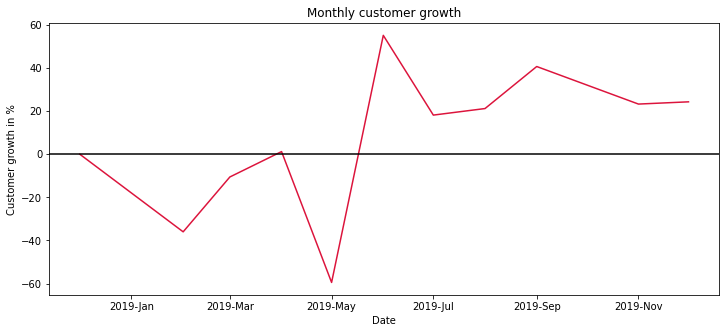

In [23]:
# Find the monthly customer growth rate
temp=sales.copy(deep=True)
temp=temp.groupby(by=["invoice_date"]).count().reset_index()
temp["month_beg"]=pd.DatetimeIndex(temp["invoice_date"]).is_month_start
temp=temp.loc[temp["month_beg"]]
a=temp.columns
a=[i for i in a if i not in ("invoice_date","year")]
temp.drop(a, axis=1, inplace=True)
temp.reset_index(drop=True, inplace=True)
for i in range(1,11):
    temp.loc[i,"attrition"]=100*(temp.loc[i,"year"]-
                            temp.loc[i-1,"year"])/temp.loc[i-1,"year"]
temp.fillna(0,inplace=True)

# Plotting them
fig,ax=plt.subplots(figsize=(12,5))
ax=sns.lineplot(x=temp["invoice_date"], 
                y=temp["attrition"], color="crimson")
ax.axhline(0, color="black")
ax.set_xticks(["2019-01", "2019-03", "2019-05", 
                    "2019-07", "2019-09", "2019-11"],
                ["2019-Jan", "2019-Mar", "2019-May", 
                    "2019-Jul", "2019-Sep", "2019-Nov"])
ax.set(title="Monthly customer growth", 
        xlabel="Date", ylabel="Customer growth in %")

In [10]:
#Create an interactive plot for rating distribution according to product type
%%script False
x=pd.DataFrame()
for i in products["product_type"].unique():
    temp=products.copy(deep=True)
    temp=temp.loc[temp["product_type"]==i]
    temp["rating"].reset_index(inplace=True, drop=True)
    x[i]=(temp["rating"])
x=x.fillna(-10) # Since -10 won't be inside our axis limits,
                    #it will be ignored in the graph
label={"dslr camera":"DSLR camera", "keyboard":"Keyboard", 
        "monitor":"Monitor", "mouse":"Mouse", "processor":"Processor",
        "smartphone":"Smartphone"}
a=x.columns.tolist()
a=(pd.Series(a).map(label))
x=x.values.T
# Plot it
config = dict({'scrollZoom':True, "autosizable":True})
fig=ridgeplot(samples=x, bandwidth=0.04,
                kde_points=linspace(2,5,1500), spacing=1, labels=a)
fig.update_layout(height=1000,width=1300, plot_bgcolor="white", 
                    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
                    title="Rating distribution of each product type",
                    yaxis_title="Product type",
                    xaxis_title="Rating out of 5",
                    dragmode="pan", hovermode="closest")
fig.update_traces(mode="lines")
fig.write_html("interactive_rating.html",config=config)
fig.show(config=config)

UsageError: Line magic function `%%script` not found.


In [14]:
# Create interactive plots for averaged revenues
%%script False
# First design our figure
colours={1:"darkslategrey", 2:"crimson"}
tools= "pan", "wheel_zoom"
p=figure(width=1600, height=500,
        x_axis_type="datetime",
        tools=tools, active_scroll="wheel_zoom")
p.title.text="Averaged revenues"
p.xaxis.axis_label="Date"
p.yaxis.axis_label="Sales"
p.yaxis.formatter.use_scientific=False


# Now create a weekly average dataframe and plot it
temp=pd.merge(sales,products,on="ASIN")
temp=temp.groupby(by="invoice_date").sum()
temp.reset_index(inplace=True)
temp["avg"]=(temp["total_sale"].rolling(7).sum())
temp.dropna(inplace=True)
source=ColumnDataSource(temp)
p.line("invoice_date", "avg", source=source, line_width=2, 
        color=colours[1], legend="Weekly average")

# The same but for monthly average
temp=pd.merge(sales,products,on="ASIN")
temp=temp.groupby(by="invoice_date").sum()
temp.reset_index(inplace=True)
temp["avg"]=(temp["total_sale"].rolling(30).sum())
temp.dropna(inplace=True)
source=ColumnDataSource(temp)
p.line("invoice_date", "avg", source=source, line_width=2, 
        color=colours[2], legend="Monthly average")
# Add our tools
p.add_tools(HoverTool(tooltips=[
                        ("Date", "@invoice_date{%F}"),
                        ("Monthly average", "@avg{0,}")],
                formatters={"@invoice_date": "datetime"},
                muted_policy="ignore",
                mode="vline")
        )
p.legend.location = "top_left"
p.legend.click_policy="mute"
output_file("interactive_average.html")
show(p)

UsageError: Line magic function `%%script` not found.


In [15]:
# Create interactive plot for daily sales
%%script False
temp=sales.copy(deep=True)
temp=temp.groupby(by="invoice_date").sum()
temp.reset_index(inplace=True)
source=ColumnDataSource(temp)
tools="pan", "wheel_zoom"
p=figure(width=1600, height=500,
        x_axis_type="datetime",
        tools=tools, active_scroll="wheel_zoom")
p.title.text="Daily sales"
p.xaxis.axis_label="Date"
p.yaxis.axis_label="Sales"
p.yaxis.formatter.use_scientific=False
p.line("invoice_date", "total_sale", source=source, 
        line_width=2, color="crimson")
p.add_tools(HoverTool(tooltips=[
                        ("Date", "@invoice_date{%F}"),
                        ("Sales", "@total_sale{0,}")],
                formatters={"@invoice_date": "datetime"},
                mode="vline")
        )
output_file("interactive_daily.html")
show(p)

UsageError: Line magic function `%%script` not found.


In [179]:
# Create an interactive plot for sales according to product type
%%script false
# First prepare the dataset
colours={1:"crimson",2:"fuchsia",3:"black",
        4:"royalblue",5:"orange",6:"limegreen"}
label={"dslr camera":"DSLR camera", "keyboard":"Keyboard", 
        "monitor":"Monitor", "mouse":"Mouse", "processor":"Processor",
        "smartphone":"Smartphone"}

temp=pd.merge(sales,products,on="ASIN")
temp=temp.groupby(by=["week","product_type"]).sum()
temp.reset_index(inplace=True)
temp=temp
temp["week"]=2019*100+temp["week"]
temp["week"]=temp["week"].astype(str)
temp["week"]=pd.to_datetime(temp["week"].astype(str)+"0",
                        format='%Y%W%w')

temp["product_type"].replace(label, inplace=True)
a=temp.columns
a=[i for i in a if i not in ("week", "Quantity", 
                        "total_sale", "product_type")]
temp.drop(a, axis=1, inplace=True)

# And now automate the plotting
tools= "pan","wheel_zoom"
x=1
p = figure(width=1600, height=500,
        x_axis_type="datetime",
        tools=tools, active_scroll="wheel_zoom")
p.title.text="Sales breakdown based on product type"
p.xaxis.axis_label="Date"
p.yaxis.axis_label="Sales"
p.yaxis.formatter.use_scientific=False
for i in temp["product_type"].unique():
        df=temp.loc[temp["product_type"]==i]
        source=ColumnDataSource(df)
        p.line("week", "total_sale", source=source,line_width=3, 
                color=colours[x], alpha=1.0,
                muted_color=colours[x], muted_alpha=0.3,
                legend_label=i)
        x+=1
p.add_tools(HoverTool(tooltips=[
                        ("Date", "@week{%F}"),
                        ("Orders' value", "€@total_sale{0,}"),
                        ("Orders' size", "@Quantity{0,}")],
                formatters={"@week": "datetime"},
                muted_policy="ignore",
                mode="vline")
        )
p.legend.location = "top_left"
p.legend.click_policy="mute"
output_file("interactive_product_type.html")
show(p)

UsageError: Line magic function `%%script` not found.


In [36]:
# Create interactive plots for common item-pairs of 2019
# For each month we find through a series of functions the most common
# pairs. Then we plot an interactive network graph and save that figure
# in a list. Afterwards we extract the components "script" and "div" 
# of the figures and pass them to a bokeh template html file 
%%script false
plots=[]
for i in range(1,13):
    p=node(i)
    plots.append(p)    
script, div=components(plots)

In [18]:
# Seasonal decomposition
%%script False
from statsmodels.tsa.seasonal import seasonal_decompose
temp=sales.loc[sales["year"]==2019]
temp=temp[["month","total_sale"]]
temp.set_index("month", inplace=True)
temp.index=pd.to_datetime(temp.index)
dec=seasonal_decompose(temp["total_sale"], model="additive",period=12)
dec.trend.plot()

Couldn't find program: 'False'


In [19]:
# Attempt at web scrapping for accurate ratings and up to date prices
%%script False 
# WIP
from bs4 import BeautifulSoup
import smtplib
import requests
site="https://www.amazon.de/dp/B00004THD0"
head=({"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.53 Safari/537.36 Edg/103.0.1264.37"})
r=requests.get(url=site,headers=head)
soup=BeautifulSoup(r.content, "html.parser")
title=soup.findAll("span", {"id":"productTitle"})

title

Couldn't find program: 'False'
